# Aperiodic electrophysiological activity tracks spiking statistics between behavioral states
Sawyer Figueroa, Michael Preston, Bradley Voytek

# SfN 2023, Poster Panel 4
This notebook reproduces the figures from poster panel 4. Panel 4 investigates the relationship between spike-synchrony and aperiodic LFP activity. Comparisons are made between behavioral epochs.

Dataset: Allen Institute for Brain Science: Visual Coding - Neuropixels  
© 2015 Allen Institute for Brain Science. Allen Brain Atlas API. Available from: https://portal.brain-map.org/explore/circuits/visual-coding-neuropixels

## Set-up

### set paths

In [1]:
# set paths
PROJECT_PATH = "G:/Shared drives/visual_encoding" # shared results directory
MANIFEST_PATH = 'D:/datasets/allen_vc' # path to manifest file and local dataset

### imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as sts
import statsmodels.api as sm
import os

In [4]:
# custom imports
import sys
sys.path.append('../../')
from allen_vc.plots import scatter_2_conditions
from allen_vc.utils import combine_spike_lfp_dfs, channel_medians

print("Imported!")

Imported!


### settings

In [5]:
# matplotlib and figure appearance settings
plt.style.use(f'../../stylelib/sfn_2023.mplstyle')
# COLORS = ["#7570b3", "#3FAA96", "#F39943"]

### load data

In [6]:
# load data for stim: natural_movie_one_more_repeats

# load spike data
movie_spikes = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/natural_movie_one_more_repeats.csv')

# load lfp data
# movie_lfp = pd.read_csv(f'{PROJECT_PATH}/data/lfp_data/pavrams/psd/natural_movie_one_more_repeats/lfp_params.csv')

# load lfp data - join params across sessions ! TEMP !
# this is a temporary fix: this should be performed by the analysis script
path_in = f'{PROJECT_PATH}/data/lfp_data/params/psd/natural_movie_one_more_repeats/by_session'
files = os.listdir(path_in)
df_list = []
for fname in files:
    df_list.append(pd.read_csv(f'{path_in}/{fname}'))
movie_lfp = pd.concat(df_list, axis=0)

In [7]:
# load data for stim: natural_movie_one_shuffled

# load spike data
shuffled_spikes = pd.read_csv(f'{PROJECT_PATH}/data/spike_stats/natural_movie_one_shuffled.csv')

# load lfp data
# shuffled_lfp = pd.read_csv(f'{PROJECT_PATH}/data/lfp_data/params/psd/natural_movie_one_shuffled/lfp_params.csv')

# load lfp data - join params across sessions ! TEMP !
# this is a temporary fix: this should be performed by the analysis script
path_in = f'{PROJECT_PATH}/data/lfp_data/params/psd/natural_movie_one_shuffled/by_session'
files = os.listdir(path_in)
df_list = []
for fname in files:
    df_list.append(pd.read_csv(f'{path_in}/{fname}'))
shuffled_lfp = pd.concat(df_list, axis=0)


## Main

### Regression plot: mean firing rate vs. broadband offset 

##### Spontaneous activity: model behavioral states (running and stationary) seperately  

##### Passive viewing: model stimulus contexts (movie and shuffled) seperately; plot stationary epochs only

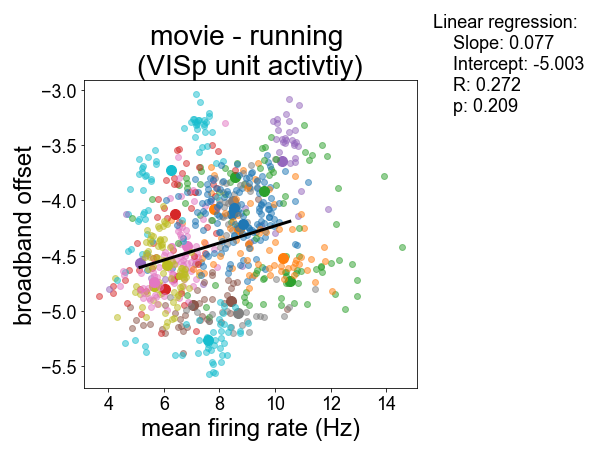

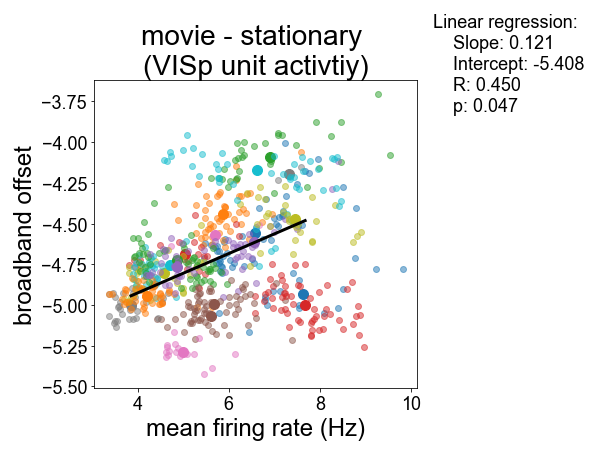

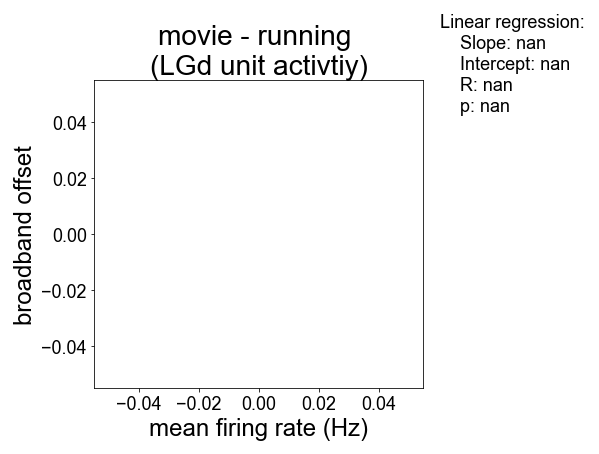

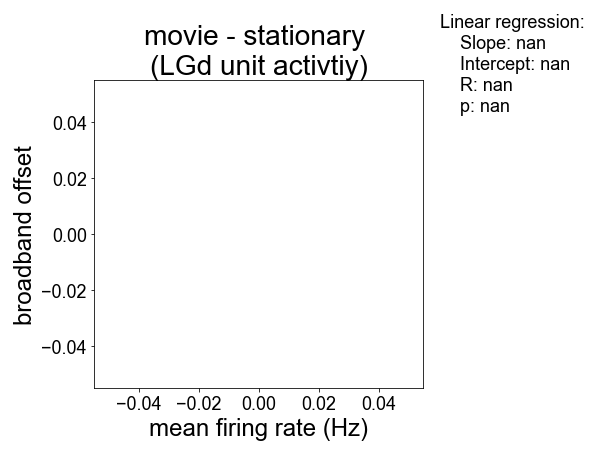

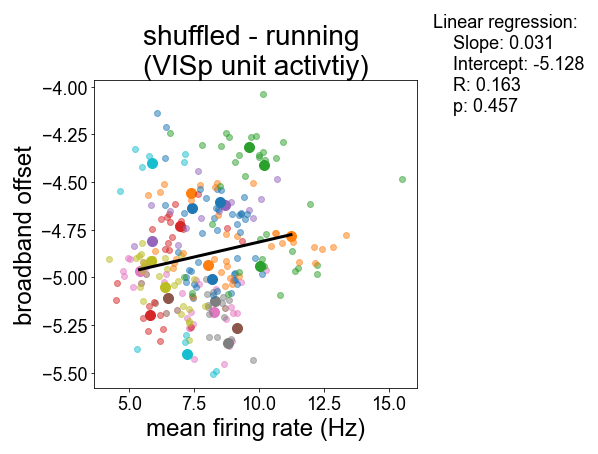

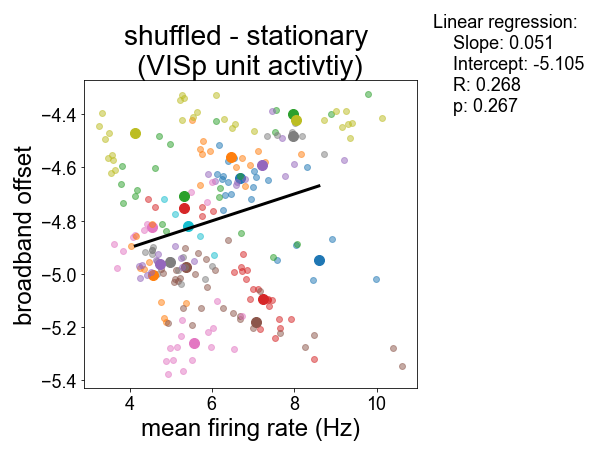

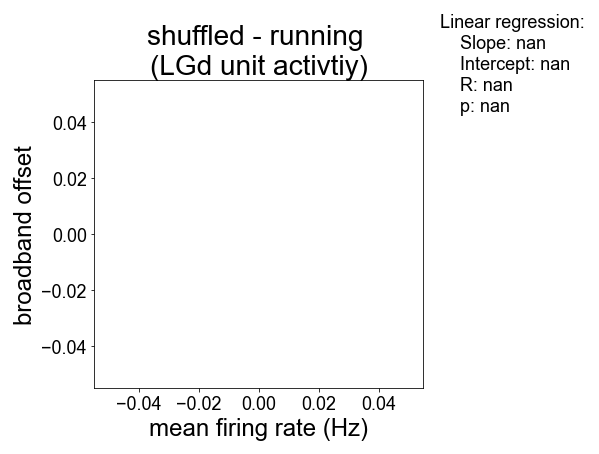

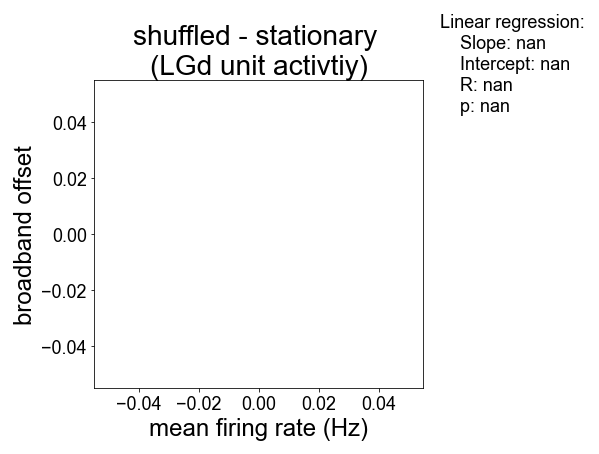

In [74]:
# loop through stimuli
for stimulus, df_lfp, df_units in zip(['movie', 'shuffled'], 
                                      [movie_lfp, shuffled_lfp],
                                      [movie_spikes, shuffled_spikes]):
    # modify df_lfp - average over channels for each epoch within each session
    df_lfp_i = df_lfp.groupby(['session', 'epoch_idx']).mean().reset_index()

    # FIX: remove space from brain structure names
    df_units['brain_structure'] = df_units['brain_structure'].str.replace(' ', '')

    # loop through spiking region
    for spike_region in ['VISp', 'LGd']:
        # get unit data for this region
        df_units_i = df_units[df_units.get("brain_structure")==spike_region]  

        # merge unit and lfp dataframes
        df_i = df_lfp_i.merge(df_units_i, on=['session', 'epoch_idx'])

        # loop through behavioral conditions
        for behavior, running in zip(['running', 'stationary'], [True, False]):

            # filter df by behavior
            df = df_i[df_i.get('running')==running]
            
            # plot each session
            sessions = df.get('session').unique()
            fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
            fig.patch.set_facecolor('white')
            for ses in sessions:
                ses_df = df[df.get('session')==ses]

                # plot each epoch
                sc =  ax.scatter(ses_df.get('mean_firing_rate'), 
                                 ses_df.get('offset'), label=ses)

                # plot session mean
                ax.scatter(ses_df.get('mean_firing_rate').mean(), 
                           ses_df.get('offset').mean(), color=sc.get_facecolors()[0], s=100)
                sc.set_alpha(0.5)
                
            # run regression across all epochs and plot results
            df_avg = df.groupby(['session']).mean().reset_index()# average across trials
            x_data = df_avg.get('mean_firing_rate')
            y_data = df_avg.get('offset')
            results = sts.linregress(x_data, y_data)
            l1 = np.linspace(min(x_data), max(x_data), 1000)
            t1 = results.slope * l1 + results.intercept
            ax.plot(l1, t1, color='k', linewidth=3)

            # add regression results text
            if results.pvalue < 0.001:
                pval = f"{results.pvalue:.2e}"
            else:
                pval = f"{results.pvalue:.3f}"
            plt.text(1.05, 0.9, 
                    f"Linear regression:\n" +
                    f"    Slope: {results.slope:.3f}\n" +
                    f"    Intercept: {results.intercept:.3f}\n" +
                    f"    R: {results.rvalue:.3f}\n" +
                    f"    p: {pval}", transform = ax.transAxes)

            # label
            # ax.legend(bbox_to_anchor=(1.05, -.1), loc='lower left', borderaxespad=0.)
            plt.xlabel("mean firing rate (Hz)")
            plt.ylabel("broadband offset")
            plt.title(f"{stimulus} - {behavior} \n({spike_region} unit activtiy)")
            
            # save
            dir_figures = f"{PROJECT_PATH}/figures/offset_vs_rate/{spike_region}/{behavior}"
            # plt.savefig(f"{dir_figures}/all_sessions")

### Regression plot: SPIKE-distance vs. LFP exponent 

##### Spontaneous activity: model behavioral states (running and stationary) seperately  

##### Passive viewing: model stimulus contexts (movie and shuffled) seperately; plot stationary epochs only

In [ ]:
# loop through stimuli
for stimulus, df_lfp, df_units in zip(['movie', 'shuffled'], 
                                      [movie_lfp, shuffled_lfp],
                                      [movie_spikes, shuffled_spikes]):
    # modify df_lfp - average over channels for each epoch within each session
    df_lfp_i = df_lfp.groupby(['session', 'epoch_idx']).mean().reset_index()

    # loop through spiking region
    for spike_region in ['VISp', 'LGd']:
        # get unit data for this region
        df_units_i = df_units[df_units.get("brain_structure")==spike_region]  

        # merge unit and lfp dataframes
        df_i = df_lfp_i.merge(df_units_i, on=['session', 'epoch_idx'])

        # loop through behavioral conditions
        for behavior, running in zip(['running', 'stationary'], [True, False]):

            # filter df by behavior
            df = df_i[df_i.get('running')==running]

            # create figure
            fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
            fig.patch.set_facecolor('white')

            # plot each session
            sessions = df.get('session').unique()
            for ses in sessions:
                ses_df = df[df.get('session')==ses]

                # plot each epoch
                sc =  ax.scatter(ses_df.get('spike_distance'), 
                                 ses_df.get('exponent'), label=ses)

                # plot session mean
                ax.scatter(ses_df.get('spike_distance').mean(), 
                           ses_df.get('exponent').mean(), color=sc.get_facecolors()[0], s=100)
                sc.set_alpha(0.5)
                
            # run regression across all epochs and plot results
            df_avg = df.groupby(['session']).mean().reset_index()# average across trials
            x_data = df_avg.get('spike_distance')
            y_data = df_avg.get('exponent')
            results = sts.linregress(x_data, y_data)
            l1 = np.linspace(min(x_data), max(x_data), 1000)
            t1 = results.slope * l1 + results.intercept
            ax.plot(l1, t1, color='k', linewidth=3)

            # add regression results text
            if results.pvalue < 0.001:
                pval = f"{results.pvalue:.2e}"
            else:
                pval = f"{results.pvalue:.3f}"
            plt.text(1.05, 0.9, 
                    f"Linear regression:\n" +
                    f"    Slope: {results.slope:.3f}\n" +
                    f"    Intercept: {results.intercept:.3f}\n" +
                    f"    R: {results.rvalue:.3f}\n" +
                    f"    p: {pval}", transform = ax.transAxes)

            # label
            ax.legend(bbox_to_anchor=(1.05, .8), loc='upper left', borderaxespad=0.)
            plt.xlabel("SPIKE-distance")
            plt.ylabel("LFP exponent")
            plt.title(f"{stimulus} - {behavior} \n({spike_region} unit activtiy)")
            
            # save
            dir_figures = f"{PROJECT_PATH}/figures/exponent_vs_synchrony/{spike_region}/{behavior}"
            # plt.savefig(f"{dir_figures}/all_sessions")

### Statistics

#### Linear regression

In [ ]:
# look at parameter comparisons

# spike_sync vs. exponent graph + pearson R
# offset vs. firing rate

# SPLIT BASED ON BEHAVIOR

In [ ]:
# # nans for this session maybe missing lfp data in this last few epochs? (should be 44 below epochs), NOTE: session has nans in lfp

# e = params_df[params_df['session']==847657808]['epoch_idx'].unique()
# e

In [ ]:
# # drop nans
# other_sessions = metric_df[(metric_df['session'] != 847657808)]
# nan_session = metric_df[(metric_df['session'] == 847657808) & (metric_df['epoch_idx'].isin(e[~np.isnan(e)]))]

# metric_df = pd.concat([other_sessions, nan_session])

In [ ]:
# get VISp spike data

# load spike stats
metric_fp = f'{PROJECT_PATH}/data/spike_stats/no_behavior/spontaneous_running.csv'
metric_df = pd.read_csv(metric_fp)

# # get VISp rows
# m = metric_df[metric_df['brain_structure']=='LGd']

# # rename running column
# m = m.rename(columns={'running':'behavior'})
# m
metric_df

In [ ]:
# load LFP spectral params
params_r = pd.read_csv(f'{PROJECT_PATH}/data/lfp_data/params/psd/spontaneous_running/lfp_params.csv')
params_r['behavior'] = 'above'
params_s = pd.read_csv(f'{PROJECT_PATH}/data/lfp_data/params/psd/spontaneous_stationary/lfp_params.csv')
params_s['behavior'] = 'below'
params_df = pd.concat([params_r, params_s], axis=0)
params_df

In [ ]:
# compute median across LFP channels
p = params_df.groupby(['session','behavior','epoch_idx']).median().reset_index().drop(columns='chan_idx')
p['epoch_idx'] = p['epoch_idx'].apply(int)
p

In [ ]:
# merge spike and LFP results
df = m.merge(p, on=['session','behavior','epoch_idx'])
df

In [ ]:
def linregress_plot(x, y):
    # imports
    from scipy.stats import linregress

    # remove NaN
    nan_items = np.logical_or(np.isnan(x), np.isnan(y))
    x = x[~nan_items]
    y = y[~nan_items]
    
    # set up plot
    fig, ax = plt.subplots(figsize=(16,12), constrained_layout=True)
    fig.patch.set_facecolor('white')
    
    # plot data
    sns.scatterplot(x=x, y=y)

    # run regression and plot results
    results = linregress(x, y)
    t_lin = np.linspace(np.nanmin(x), np.nanmax(x), 100)
    lin = results.slope * t_lin + results.intercept
    ax.plot(t_lin, lin, color='r')

    # add regression results text
    if results.pvalue < 0.001:
        pval = f"{results.pvalue:.2e}"
    else:
        pval = f"{results.pvalue:.3f}"
    plt.text(1.05, 0.9, 
             f"Regression:\n" +
             f"    Slope: {results.slope:.3f}\n" +
             f"    Intercept: {results.intercept:.3f}\n" +
             f"    R: {results.rvalue:.3f}\n" +
             f"    p: {pval}", transform = ax.transAxes, fontsize=15)
    
    return results

In [ ]:
# plot offset v rate

results = linregress_plot(x=df['mean_firing_rate'], y=df['offset'])
plt.xlabel('mean firing rate (spikes/sec)')
plt.ylabel('broadband offset');

In [ ]:
# plot exponent v synchrony

results = linregress_plot(x=df['spike_distance'], y=df['exponent'])
plt.xlabel('SPIKE-distance')
plt.ylabel('LFP exponent');

In [ ]:
# # remove outliers and plot
# no_outlier_df = df[df['spike_distance'] > 0.25]

# linregressplot(x=no_outlier_df['spike_distance'], y=no_outlier_df['exponent'])
# plt.xlabel('SPIKE-distance')
# plt.ylabel('LFP exponent');

In [ ]:
# repeat for running epochs only
behav_df = df.loc[df['behavior'] == 'above']

results = linregress_plot(x=behav_df['spike_distance'], y=behav_df['exponent'])
plt.xlabel('SPIKE-distance')
plt.ylabel('LFP exponent')
plt.title('Running');

In [ ]:
# repeat for stationary epochs only

behav_df = df[df['behavior'] == 'below']

results = linregress_plot(x=behav_df['spike_distance'], y=behav_df['exponent'])
plt.xlabel('SPIKE-distance')
plt.ylabel('LFP exponent')
plt.title('Stationary');

#### Linear mixed effect model